# PublicSource Residential Price Analysis

By Nora Mattson, Data Intern

This analysis was conducted to support visualizations for a PublicSource article about [community land trusts](https://www.publicsource.org/community-land-trusts-new-to-pittsburgh-shaped-by-pittsburgh/). Since the article relied upon assumptions about changes in the housing market, we thought that it would be relevant to show the audience what these changes were by visualizing the median housing prices in each of the neighborhoods setting up a community land trust. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

We used WPRDC's [Parcels n'at tool](http://tools.wprdc.org/parcels-n-at/#) because it makes it nice and easy to replicate with these or other neighborhoods. However, it is important to note that county assessment data doesn't always have the most updated real estate transactions, which is why we are only analyzing 2008-2018. Take a look at this [assessment data user guide](https://docs.google.com/document/d/1eYuJOh4_CBitclhhgeJv6iLStPjtouhXV1_2cwei_-s/edit) from WPRDC if you are interested in learning more about this data. 

In [2]:
neighborhoods = ["westoakland","bedforddwellings","centrallv","centraloakland","crawfordroberts","etna", 
                 "fineview","garfield","lowerlv","middlehill","millvale","northoakland","perryhilltop",
                 "polishhill","sharpsburg","southoakland","terracevillage","upperhill","upperlv"]
#data from WRPDC's parcels n'at tool, select the "house hunting" custom field list and add owner description

Then we put all of the different CSVs into a dataframe for analysis.

In [3]:
dfs = []
#add all of the neighborhoods to the dataframe
for nbhd in neighborhoods:
    df = pd.read_csv("median/%s.csv"%(nbhd))
    df["neighborhood__asmt"] = nbhd
    dfs.append(df)
meddf = pd.concat(dfs)
#rename columns
meddf.rename(columns=lambda x: x[:-6], inplace=True)

The Hill District is broken up into a bunch of smaller communities, as is Oakland and Lawrenceville, so we will go ahead and group them together. Additionally, let's look at the neighborhoods being grouped for community land trusts, Perry Hilltop and Fineview, as well as Etna, Millvale and Sharpsburg, together, which will mirror how they are discussed in the article and increase the sample size of the groups we are looking at. 

In [4]:
#rename all of the neighburhoods with multiple census tracts
meddf.loc[meddf["neighborhood"].isin(["westoakland", "centraloakland","northoakland","southoakland"]), "neighborhood"] = "oakland"
meddf.loc[meddf["neighborhood"].isin(["bedforddwellings", "crawfordroberts","upperhill","terracevillage","middlehill"]), "neighborhood"] = "hilldistrict"
meddf.loc[meddf["neighborhood"].isin(["upperlv", "centrallv","lowerlv"]), "neighborhood"] = "lawrenceville"
#for the sake of this analysis, we are grouping neighborhoods that are forming a CLT together
meddf.loc[meddf["neighborhood"].isin(["etna", "millvale","sharpsburg"]), "neighborhood"] = "riverboroughs"
meddf.loc[meddf["neighborhood"].isin(["perryhilltop", "fineview",]), "neighborhood"] = "perryhilltop/fineview"

meddf["neighborhood"].unique()

array(['oakland', 'hilldistrict', 'lawrenceville', 'riverboroughs',
       'perryhilltop/fineview', 'garfield', 'polishhill'], dtype=object)

### Cleaning

In [5]:
def residential(df):
    '''Filter so we are only looking at residential properties that have an actual structure on them.'''
    #Only looking at residential properties 
    df = df[df.CLASSDESC == "RESIDENTIAL"]
    #not looking at vacant properties
    df = df.loc[df.USEDESC !='VACANT LAND']
    return df

In the next step, we filter out sales that have been marked as invalid. We are interested in prices an ordinary buyer might actually find on the real estate, so prices that are lower because properties have been bundled, or because the seller is selling it to a family member for ten dollars, or higher because it involves a forced sale to the government, aren't that relevant for us. I decided to include sales that haven't been reviewed yet, so after that I went ahead and filtered out all sales less than $500 for a house, because those are likely invalid. [Here](https://data.wprdc.org/dataset/real-estate-sales/resource/96474373-bcdb-42cf-af5d-3683e326e227) is the dictionary for the validation codes.

In [6]:
def validate(df):
    '''Filtering out sales that have been labeled as invalid representations of actual market price.'''
    #Making sure has been tagged as a valid sale
    #'AA' indicates the sale has not been looked at, '0' indicates that it is a 'valid' sale, 'U' and'UR' mean it has been marked valid in a preliminary review. 
    df = df[df["SALECODE"].isin(['AA','0','U','UR'])]
    df = df[df.SALEPRICE >500]
    return df

The dataset includes the three most recent sales of each property, so I had to separate out the other two most recent sales so they can all be included in the analysis.

In [7]:
def separate(df):
    '''Seperating out each sale as a new row.'''
    #this dataset records the three most recent sales
    df["SALEYEAR"] = df.SALEDATE.str[-4:]
    df["PREVSALEYEAR"] = df.PREVSALEDATE.str[-4:]
    df["PREVSALEYEAR2"] = df.PREVSALEDATE2.str[-4:]
    #we only care about the prices
    price = df[["SALEYEAR","SALEPRICE","neighborhood"]]
    #add on the previous sale
    prev_price = df[['PREVSALEYEAR','PREVSALEPRICE',"neighborhood"]]
    prev_price.columns = ["SALEYEAR","SALEPRICE","neighborhood"]
    #add on the next previous sale
    prev_price2 = df[["PREVSALEYEAR2","PREVSALEPRICE2","neighborhood"]]
    prev_price2.columns = ["SALEYEAR","SALEPRICE","neighborhood"]
    allprice = price.append([prev_price.dropna(),prev_price2.dropna()], ignore_index = True,sort=True)
    #make the years numbers so we can compare them
    allprice["SALEYEAR"] = pd.to_numeric(allprice["SALEYEAR"])
    #filter out the sales under 500 again, because the past sales prices don't include validation codes
    allprice = allprice[allprice.SALEPRICE >500]
    return allprice

Finally, we filter the dataset so we are only looking at 2008-2018, because we only really interested in recent trends for this particular application. 

In [8]:
def clean(df):
    '''Cleaning the data and cutting it down to the years we are looking at.'''
    res = residential(df)
    val = validate(res)
    allprice = separate(val)
    #looking at years after housing crisis that have enough data 
    allprice = allprice[(allprice.SALEYEAR>2007)&(allprice.SALEYEAR<2019)]
    return allprice

In [9]:
medval = clean(meddf)
medval.head(5)

,SALEPRICE,SALEYEAR,neighborhood
0,112000.0,2012,oakland
4,85000.0,2016,oakland
6,110000.0,2010,oakland
9,81500.0,2008,oakland
11,86500.0,2010,oakland


In [10]:
medgroup = medval.groupby(["neighborhood","SALEYEAR"]).agg([np.median])["SALEPRICE"]
medgroup.unstack()

median                                          \
SALEYEAR                  2008      2009      2010      2011      2012   
neighborhood                                                             
garfield               55600.0   22250.0   16050.0   19950.0   48000.0   
hilldistrict           82609.0  121500.0   30000.0   36000.0   43900.0   
lawrenceville          57500.0   65000.0   71750.0   56250.0   70000.0   
oakland                97000.0  123725.0  110750.0  110000.0  107000.0   
perryhilltop/fineview  13300.0   46000.0    8750.0   14950.0   21275.5   
polishhill             42988.0   46550.0   69900.0   46000.0   82000.0   
riverboroughs          46000.0   63450.0   65000.0   59750.0   58000.0   

                                                                         \
SALEYEAR                   2013      2014      2015      2016      2017   
neighborhood                                                              
garfield                72500.0   56180.0   63500.0   65000.0   82000.0   
hilldistrict            63500.0  130000.0   81250.0   67500.0   60500.0   
lawrenceville           90000.0   71000.0  175000.0  182750.0  215000.0   
oakland                150000.0  135500.0  140000.0  179000.0  180000.0   
perryhilltop/fineview   35000.0   35000.0   48000.0   53500.0   67450.0   
polishhill              53500.0  107125.0  114000.0   90605.0  177500.0   
riverboroughs           69513.0   65000.0   64450.0   65000.0   63000.0   

                                 
SALEYEAR                   2018  
neighborhood                     
garfield               110000.0  
hilldistrict            55278.0  
lawrenceville          277000.0  
oakland                185407.0  
perryhilltop/fineview   44700.0  
polishhill             155500.0  
riverboroughs           61500.0

Take a look at the amount of data for each year. Note that some neighborhoods, like Polish Hill and Garfield have less data available, which might explain some of the fluctuations in their medians. 

In [26]:
medsize = medval.groupby(["neighborhood","SALEYEAR"]).agg([np.size])["SALEPRICE"]
medsize.columns={"sample_size"}
medsize.unstack()

sample_size                                              \
SALEYEAR                     2008  2009  2010   2011   2012  2013  2014  2015   
neighborhood                                                                    
garfield                     17.0   6.0  12.0   30.0   23.0  10.0  12.0  10.0   
hilldistrict                 29.0  20.0  17.0   28.0   23.0  16.0   7.0  12.0   
lawrenceville                68.0  69.0  77.0  110.0  109.0  91.0  52.0  56.0   
oakland                      65.0  78.0  72.0   80.0   65.0  75.0  36.0  31.0   
perryhilltop/fineview        38.0  17.0  26.0   44.0   30.0  16.0  19.0  20.0   
polishhill                    8.0   8.0   9.0    7.0   11.0   4.0   4.0   7.0   
riverboroughs                77.0  62.0  63.0   58.0   77.0  52.0  33.0  38.0   

                                         
SALEYEAR               2016  2017  2018  
neighborhood                             
garfield               14.0  17.0  19.0  
hilldistrict           13.0  28.0  21.0  
lawrenceville          62.0  66.0  65.0  
oakland                37.0  39.0  49.0  
perryhilltop/fineview  19.0  22.0  27.0  
polishhill              6.0   6.0   5.0  
riverboroughs          45.0  55.0  68.0

Let's do a quick visualization of the medians, we need to flip the order of "SALEYEAR", "neighborhood" in the groupby to actually plot it, because I just like how the other order displayed in the earlier table.

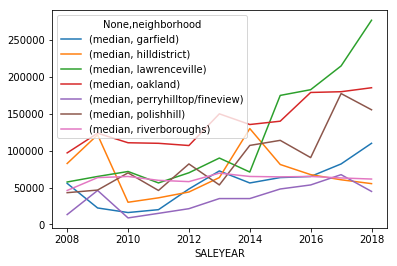

In [12]:
medval.groupby(["SALEYEAR","neighborhood"]).agg([np.median])["SALEPRICE"].unstack().plot()

Finally, here is the graphic in the article: 
![Median Prices](land_trust_graphics/median.png)